In [1]:
from ISLP import load_data
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [2]:
data = load_data('Wage')

In [3]:
data

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154
...,...,...,...,...,...,...,...,...,...,...,...
2995,2008,44,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,5.041393,154.685293
2996,2007,30,2. Married,1. White,2. HS Grad,2. Middle Atlantic,1. Industrial,2. >=Very Good,2. No,4.602060,99.689464
2997,2005,27,2. Married,2. Black,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.193125,66.229408
2998,2005,27,1. Never Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,4.477121,87.981033


In [4]:
from ISLP.transforms import BSpline, NaturalSpline
from ISLP.models import summarize, poly, bs, ModelSpec as MS

In [5]:
# preprocess
obj = data.dtypes[data.dtypes == 'object'].index
cat = data.dtypes[data.dtypes == 'category'].index

from sklearn.preprocessing import OrdinalEncoder

for i in obj:
    encoder = OrdinalEncoder()
    encoder.fit(list(data[i].values.reshape(-1,1)))
    data[i] = encoder.transform(list(data[i].values.reshape(-1,1)))

for i in cat:
    encoder = OrdinalEncoder()
    encoder.fit(list(data[i].values.reshape(-1,1)))
    data[i] = encoder.transform(list(data[i].values.reshape(-1,1)))

### 3a)

In [6]:
# fit cubic spline to wage
y = data['wage']
age = data['age']

bs_ = BSpline(internal_knots=[30,50,60], intercept=True).fit(age)
bs_Age = bs_.transform(age)
bs_Age = MS([bs('age', internal_knots=[30,50,60], name='bs(age)')])
Xbs = bs_Age.fit_transform(data)
model = sm.GLM(y, Xbs).fit()
summarize(model)

,coef,std err,z,P>|z|
intercept,59.1945,7.704,7.683,0.000
bs(age)[0],13.5360,10.938,1.238,0.216
bs(age)[1],66.3401,7.738,8.573,0.000
bs(age)[2],56.2070,9.197,6.112,0.000
bs(age)[3],64.2794,8.895,7.226,0.000
bs(age)[4],36.9443,15.764,2.344,0.019
bs(age)[5],25.6901,18.765,1.369,0.171


In [7]:
age_grid = np.linspace(data.age.min(), data.age.max(),100)
age_df = pd.DataFrame({'age': age_grid})

In [8]:
import matplotlib.pyplot as plt

# transform age grid into an interpretable dataframe
ages = BSpline(internal_knots=[30,50,60], intercept=True).fit(age_df.age)
ages_ = ages.transform(age_df.age)
ages_ = MS([bs('age', internal_knots=[30,50,60], name='bs(age)')])
Xin = ages_.fit_transform(age_df)

# make predictions
pred = model.predict(Xin)

In [9]:
age_df['predictions'] = pred

Text(0, 0.5, 'wage')

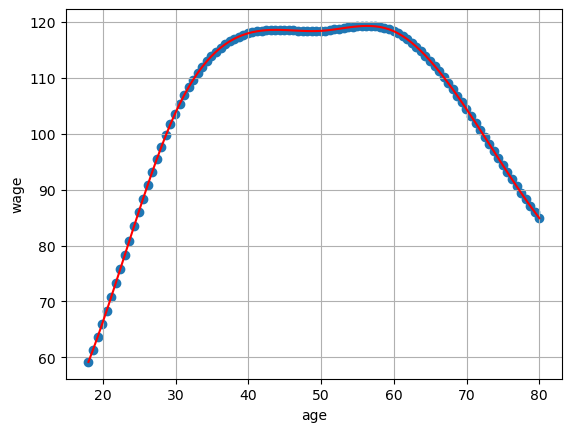

In [10]:
plt.grid()
plt.scatter(age_df.age, age_df.predictions)
plt.plot(age_df.age, age_df.predictions, color='r')
plt.xlabel('age')
plt.ylabel('wage')

The GLM appears to predict approximately 104 to 105k as the wage for your average 30 year old.

### 3b)

In [11]:
# fit a GAM to this which has a smoothing function (pygam); see textbook
X_age = data['age'].values.reshape(-1,1)

from pygam import LinearGAM, s

# find optimal lambda
gam = LinearGAM(s(0, lam=0.6))
gridsearch = gam.gridsearch(X_age, y)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [12]:
age_dataframe = pd.DataFrame({'age': age_grid})
smoooth_predictions = gridsearch.predict(age_grid)
age_dataframe['predictions'] = smoooth_predictions

Text(0, 0.5, 'wage')

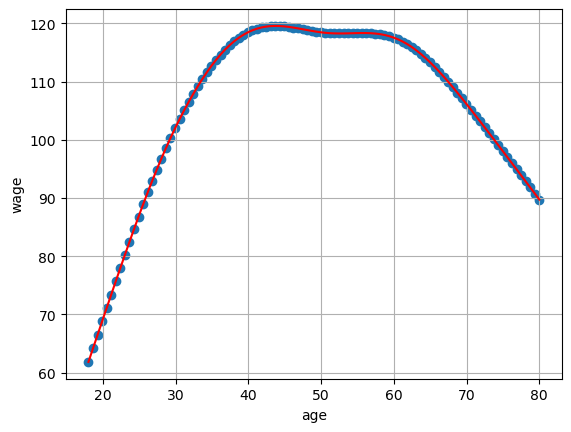

In [13]:
plt.grid()
plt.scatter(age_dataframe.age, age_dataframe.predictions)
plt.plot(age_dataframe.age, age_dataframe.predictions, color='r')
plt.xlabel('age')
plt.ylabel('wage')

For a 30 year old, the prediction ranges between 101 to 103k.

### 3c)

In [14]:
age = data['age']
marital = data['maritl']
y = data['wage']

In [15]:
ns_age = NaturalSpline(df=4).fit(age)
#ns_marital = NaturalSpline(df=4).fit(marital)

# transform into an interpretable structure
X = pd.concat([ns_age.transform(age), marital], axis=1)

# stack together from list of arrays
#X_Stacked = np.hstack(X)

# fit to model
gam = LinearGAM().fit(X, y)
# define an age an year grid; just rewrite over previous grid
age_grid = np.linspace(age.min(), age.max(), 100)
ns_agesIn = NaturalSpline(df=4).fit_transform(age_grid)

# define a grid for maritl variable; no need to transform; maybe use linear space?
# maritl_grid = [np.random.randint(0.0, 5.0) for _ in range(100)]
maritl_grid = np.linspace(marital.min(), marital.max(), 100)
# create dataframe
X_in = pd.DataFrame(ns_agesIn)
X_in['maritl'] = maritl_grid
# cast to float; unneeded if using linspace
# X_in['maritl'] = X_in['maritl'].astype(float)
# make predictions
preds = gam.predict(X_in)

# new dataframe for plotting
plotting_df = pd.DataFrame({'ages': age_grid, 'maritl':maritl_grid, 'predictions': preds})
# plotting_df

Text(0, 0.5, 'wage')

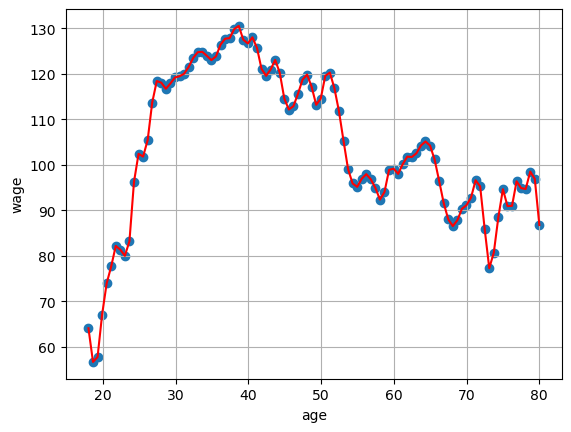

In [16]:
plt.grid()
plt.scatter(plotting_df.ages, plotting_df.predictions)
plt.plot(plotting_df.ages, plotting_df.predictions, color='r')
plt.xlabel('age')
plt.ylabel('wage')

In [17]:
# create a prediction for a married 30 year old
age = np.linspace(30,31, 4)
ns_age = NaturalSpline(df=4).fit_transform(age)
status = np.linspace(1,2,4)
df = pd.DataFrame(ns_age)
df['maritl'] = status

In [18]:
print('The mean prediction for a married 30 year old is $',gam.predict(df)[0:3].round(2).mean(), '(in thousands)')

The mean prediction for a married 30 year old is $ 104.46 (in thousands)


In [19]:
# this is predicting for married individuals between the ages 30 and 31. Exclude last prediction.
gam.predict(df)

array([ 77.74137214, 130.49903318, 105.1408285 ,  85.56463512])